### Particle Filtering or "Predict, resample, estimate"
Source:
+ https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
+ https://habr.com/ru/articles/276801/ (ru)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from numpy.random import seed

1.999 when GDP predict is -0.085, # of weights 373, Output Gap value -0.057
2.006 when GDP predict is 1.763, # of weights 355, Output Gap value 1.180
2.015 when GDP predict is 1.640, # of weights 352, Output Gap value 1.106
1.998 when GDP predict is 1.494, # of weights 348, Output Gap value 1.001
1.998 when GDP predict is 1.414, # of weights 347, Output Gap value 0.942
2.016 when GDP predict is 1.353, # of weights 346, Output Gap value 0.888
2.008 when GDP predict is 1.246, # of weights 344, Output Gap value 0.835
1.995 when GDP predict is 1.179, # of weights 344, Output Gap value 0.791
2.005 when GDP predict is 1.118, # of weights 342, Output Gap value 0.746


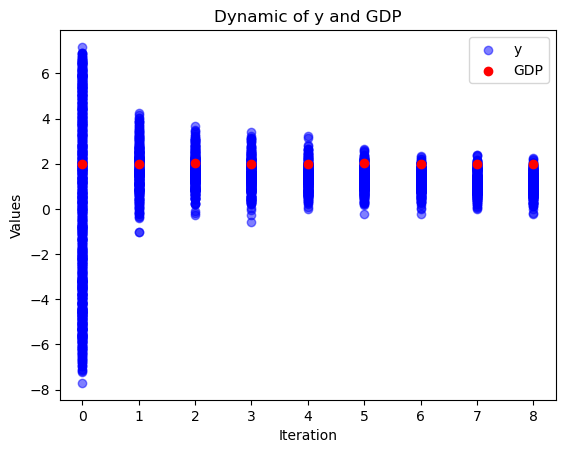

In [64]:
np.random.seed(42)  # for reproducibility
periods = 10
GDP = np.random.normal(2, 0.01, periods)
N = 1000
theta = 0.3
epsilon = 0.1
# initial x values
x = np.random.uniform(-5, 5, N)
# initializing weights
weights = np.ones(N) / N

for i in range (periods - 1):
    size = len(weights[weights > 0])
    x = np.random.choice(x, size=size, p=weights)
    x = 0.9 * x + np.random.normal(0, epsilon, len(x))
    y = 1.5 * x + np.random.normal(0, theta, len(x))
    # update weights
    weights = scipy.stats.norm.pdf(y, loc=GDP[i+1])
    weights /= np.sum(weights)
    weights[weights < 1/size/5] = 0 # drop values with low weights
    weights /= np.sum(weights)
    print(f"{GDP[i+1]:.3f} when GDP predict is {y.mean():.3f}, # of weights {len(weights[weights > 0])}, Output Gap value {x.mean():.3f}")
    plt.scatter([i] * size, y, color='blue', alpha=0.5, label='y' if i == 0 else "")
    plt.scatter(i, GDP[i+1], color='red', label='GDP' if i == 0 else "")

plt.xlabel("Iteration")
plt.ylabel("Values")
plt.title("Dynamic of y and GDP")
plt.legend()
plt.show()